# Predicting the survivors of the titanic

### [Import the packages](#import)
### [Load the data](#load)
### [Exploratory data analysis](#eda)
#### [Data Visualisation](#data_visualisation)
### [Data cleaning](#cleaning)
##### [Feature selection](#feature_selection)
##### [Missing Values (Feature imputation)](#missing_values)
##### [Outliers](#outliers)
### [Pre-processing](#pre_processing)
##### [Split your data into training, validation, and testing](#train_test_split)
##### [Feature selection / engineering](#feature_selection)
##### [Feature encoding](#feature_encoding)
##### [Standardize / Scale the data](#scale)
##### [Custom transformer classes/functions](#custom_transformer)
##### [Transformation Pipeline](#transformation_pipeline)
### [Select model and train it](#model)
### [Fine tune model](#fine_tune)
### [Test the model](#test)
#### [](#)
#### [](#)
#### [](#)
#### [](#)
##### [](#)
##### [](#)
##### [](#)
##### [](#)


# Import packages <a id='import' ><a/>

https://realpython.com/logistic-regression-python/

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Load data <a id='load' ><a/>

In [131]:
raw_train_data = pd.read_csv('train.csv')
raw_test_data = pd.read_csv('test.csv')
data = raw_train_data.copy()
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Info about the variables in the data
#### pclass 
A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

#### Age
Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

#### sibsp
The dataset defines family relations in this way...

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife (mistresses and fiancés were ignored)

#### parch
The dataset defines family relations in this way...

Parent = mother, father

Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

# Exploratory Data Analysis <a id='eda' ><a/>

1. Get to know the data with descriptives, histograms, bar plots etc. 
    * This will help get an early idea of what variables might be important, what ones might get dropped etc.

2. Identify if you have missing entries, outliers etc.

In [132]:
# get shape of data (rows and columns)
data.shape

(891, 12)

In [133]:
# get basic info (index, data type, non-null count)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [134]:
# how many unique entries are there in each column
data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [135]:
# check how many null values each variable has
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [136]:
# get summary statistics for mumerical attributes
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [137]:
# check correlation values
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [138]:
# get a quicker view on the numerical variables correlations with Survived
corr_matrix = data.corr()
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

## Data Visualisation <a id='data_visualisation' ><a/>

array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

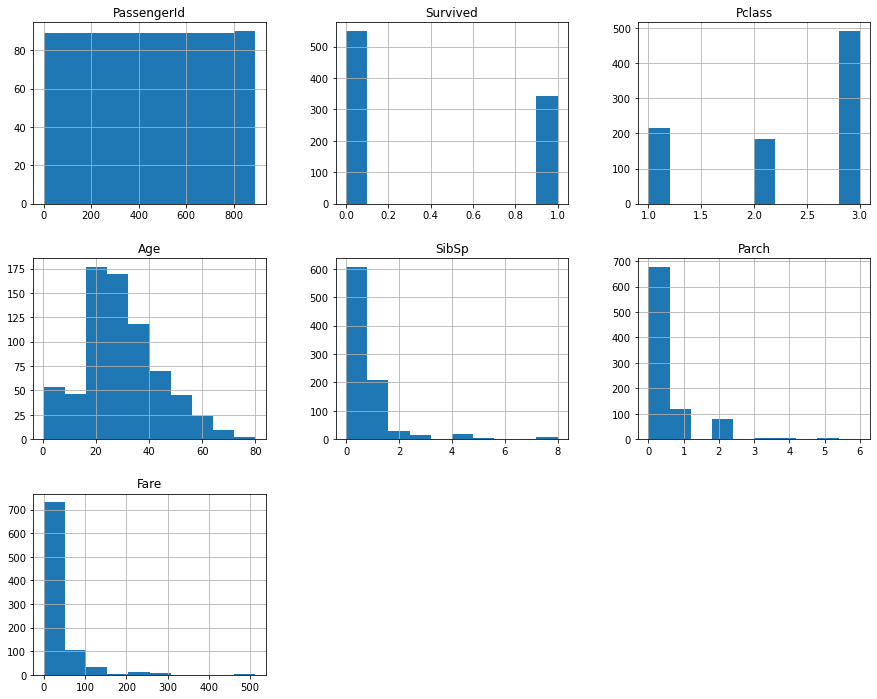

In [139]:
# plot the frequency distributions
data.hist(figsize=(15,12))

## Did the port embarked from have any influence on survival?

In [140]:
# get the unique vlaues for the ports that the ship sailed from
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [141]:
# remind ourselves how many people survived
(data['Survived']==1).sum()

342

In [142]:
# find the logic to get values for survival rates based on what port the passenger sailed from
((data['Embarked']== 'S') & (data['Survived']==1)).sum()

217

In [143]:
y = []

for i in data['Embarked'].unique():
    survived = ((data['Embarked']== i) & (data['Survived']==1)).sum()
    y.append(survived)
    
y

[217, 93, 30, 0]

The output sums to 340, meaning there are 2 missing values. This might be because _nan_ isn't a string in our array of unqiue ports. Let's change it to 'nan'.

In [144]:
ports = list(data['Embarked'].unique())
ports

['S', 'C', 'Q', nan]

In [145]:
# replace nan with 'NaN'
ports[3] = 'NaN'
ports

['S', 'C', 'Q', 'NaN']

In [146]:
# run the loop again to see if the 2 missing values fall under NaN
survived = []

for i in data['Embarked'].unique():
    survivors = ((data['Embarked']== i) & (data['Survived']==1)).sum()
    survived.append(survivors)
    
survived

[217, 93, 30, 0]

It made no difference.... perhaps those 2 are the captain and vice-captain? As it is only 2 entries I'm not too concerned so let's carry on...

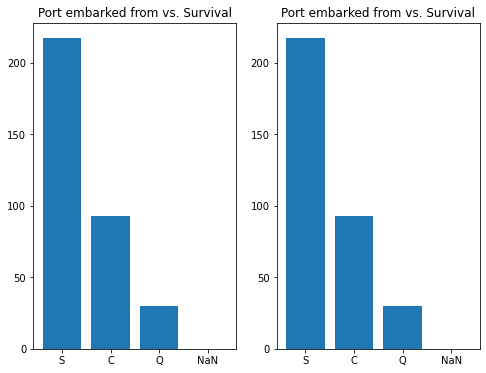

In [147]:
# check whether port embarked from has anything interesting to reveal

# make 2 graphs to practice with matplotlib!
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

ax[0].bar(x=ports, height=survived)
ax[0].set_title("Port embarked from vs. Survival")

ax[1].bar(x=ports, height=survived)
ax[1].set_title("Port embarked from vs. Survival")

plt.show()

* The bar chart reveals that the majority of the survivors embarked from Southampton. 
* Were the passengers that embarked from Southampton all in the same section of the ship, or was the section they stayed in determined by their ticket? 
* Perhaps those who embarked from Southamption were of a certain socio-economic class meaning they had a similarly priced ticket and therfore were in the same section of the ship. 
* But this would assume that passengers were all in their rooms when the ship crashed.
* Should Embarked be kept as a feature or could this be a red herring that will lead to the system learning incorrectly?? I'm going to keep it in, which will mean we have to encode the letters to 1s and 0s later on. Remember that these will be labelled 0,1,3 but they are not related (not ordinal) so consider this when encoding!

# Data cleaning <a id='cleaning' ><a/>

### Missing Values (Feature imputation) <a id='missing_values' ><a/>
* A machine learning model can’t learn on data that isn’t there!
* Single imputation: Fill with mean or median of the column.
* Multiple imputations: Model other missing values and with what your model finds.
* Many more, such as random imputation, last observation carried forward (for time series), moving window, and most frequent value.

In [151]:
# Cabin had 687 missing values and Age has 177 missing values - let's check what % of all observations this is
cabin_mv = (687/891)*100
cabin_mv = round(cabin_mv, 1)
age_mv = (177/891)*100
age_mv = round(age_mv, 1)

print(f"Cabin missing values: {cabin_mv}% of all observations")
print(f"Age missing values: {age_mv}% of all observations")

Cabin missing values: 77.1% of all observations
Age missing values: 19.9% of all observations


* Cabin is missing well over 20% so let's drop this column when it comes to feature selection. 
* 'Age' will be kept and the missing values will be filled with the median using the Scikit-learn class _SimpleImputer()_ 
* **Note:** Even though only 'Age' has missing values we'll fill these missing values using the imputer class so that we can transform new data as we can't be sure that there won't be missing values in new data (this is just good practice - there obviously won't be fresh data for this Titanic dataset!!)

In [153]:
# go through the steps to create a simple imputer and fill missing values and then later on we'll create a full transformer
imputer = SimpleImputer(strategy='median')

In [154]:
# create a copy of the data without the text attributes 'Sex'



### Feature selection <a id='feature_selection' ><a/>
* By now it's clear what features will be useful and useless, so let's drop the useless columns.


In [148]:
# remind ourselved of the columns
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [149]:
# remind ourselves of non-null values for each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [150]:
# it was decided earlier that Cabin was to be dropped
# passenger ID and Name are unlikely to have any bearing on survival chances so we'll drop these columns
data_cleaned = data.drop(columns=['PassengerId', 'Name', 'Cabin'], axis=1)
data_cleaned.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


### Outliers <a id='outliers' ><a/>
* Decide how to handle outliers (if there are any).

# Pre-processing <a id='pre_processing' ><a/>
_Prepare the data to better expose the underlying patterns to machine learning algorithms_

### Split your data into training, validation, and testing <a id='train_test_split' ><a/>
* Separate the predictors and labels
* Might require stratified sampling

### Feature engineering <a id='feature_engineering' ><a/>
* Can we / do we want to create any new features.

### Feature encoding <a id='feature_encoding' ><a/>
* Turning categorical attributes into numbers by using the fit_transform methods with OneHotEncoder(), OrdinalEncoder() etc.. A machine learning model requires all values to be numerical) (e.g., Male=1, Female=0.)

### Scale or standardize the data <a id='scale' ><a/>
* This generally leads to more accurate models

### Custom transformer classes/functions <a id='custom_transformer' ><a/>
* Custom transformers sometimes need to be created for custom clean up tasks or if you’ve created new combined attributes so that the same can quickly be done to new data.

### Transformation Pipeline <a id='transformation_pipeline' ><a/>
* Create a custom transformation piepline so that you can apply the various transformations to brand new data quickly and easily
* If you create a full transformer, apply it to the original data

In [155]:
# practice applying transformations (simple imputer, standard scaler, attributes adder and one-hot encoding) - even though 
# we won't be getting fresh data - by creating a full pipeline transformer
# see machine learning housing project for details

## Select model and train it <a id='model' ><a/>
Explore many different models and shortlist the best ones (different problems require different type of models (algorithms))
1. Choose the type of model (supervised, unsupervised, classification, regression etc.)
2. Fit the model
3. Evaluate the models using cross-validation or Scikit-Learn’s K-fold cross validation and shortlist the best ones

## Fine tune model <a id='fine_tune' ><a/>
https://realpython.com/logistic-regression-python/

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

1. Tune the hyperparameters using GridSearchCV or RandomSearchCV
2. Once you know the set of hyperparameters that achieve the best result, you can then define a new model, set the values of each hyperparameter, then fit the model on all available data. This model can then be used to make predictions on new data


## Test model on test set <a id='test' ><a/>
1. Apply any transformations to the test set (creating functions helps with this for when brand new data is fed to the model)
2. Test the model on the test data